In [242]:
import numpy as np
import pandas as pd
import pymc3 as pm
from pymc3 import Model, sample, Normal, HalfCauchy, Uniform, model_to_graphviz
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn-darkgrid')

*References*

References: I referenced Geoff Hansen's (classmate) code, the Hierarchical Model Assignment, the Model Selection Assignment, the IrisLogReg Assignment, Wikipedia, Office Hours, and Stack Overflow in the completion of this homework. 

For Problem 1, I figured out part a through office hours on 31 October. I am still struggling with this theoretical concept.

For Problem 2, I referenced Geoff's code for plot creation (in addition to this website: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.multivariate_normal.html), and to work through sampling logic. I did attempt to create a modified/improved version of his attempt, but his code structure was heavily referenced, so it will likely look similar (X1/X2 sample arrays, etc.). I made sure to understand what was happening theoretically before referencing this material. All other help was derived from assignment starter code.

For Problems 3 and 5, I referenced Geoff's code to discover the GLM model function, a way to normalize the data through a definition, and how to plot kernel density functions. All other help was derived from assignment starter code.

For Problem 4, I referenced Geoff's code to discover that a Deterministic distribution fed into the Binomial distribution for several models. This was mentioned in a class that I could not attend. His code also helped me figure out the pm.invlogit() function. All other help was derived from assignment starter code.

*Problem 4 Writeup*

NOTE TO GRADER: Unfortunately, my unpooled sampling and hiearchical model didn't complete. I ran this code overnight but it got caught in an endless "cannot divide by zero" loop. Also, my pooled sampling estimate showed strange results.

However, I can still infer key takeaways between the expected results of these models. I expected to see a poor estimate of contraception use in the pooled sampling estimate, since it does not account for districts with low amounts of data or regional factors. In contrast, the hierarchical and unpooled sampling estimates would show a more granular picture of contraception usage in bangladesh, allowing us to effectively use prior by-district information to inform our assessments.

In [243]:
## Read in the data

df=pd.read_csv("bangladesh.csv")

## Number of districts

districts=len(df.district.unique())
districts # 60

df.head()
df=df[["district","age.centered","use.contraception"]]
df

,district,age.centered,use.contraception
0,1,18.4400,0
1,1,-5.5599,0
2,1,1.4400,0
3,1,8.4400,0
4,1,-13.5590,0
...,...,...,...
1929,61,14.4400,0
1930,61,-4.5599,0
1931,61,14.4400,0
1932,61,-13.5600,0


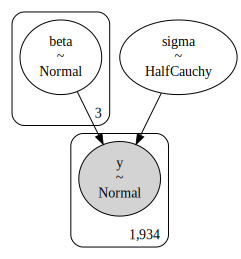

In [244]:
## Pooled model

district = df.district.values
age = df["age.centered"].values
condom=df["use.contraception"].values

with Model() as pooled_model:
    beta = pm.Normal('beta', 0, sd=1e5, shape=3) # intercept and beta parameter for predictors
    sigma = pm.HalfCauchy('sigma', 5)

    theta = beta[0] + beta[1]*district + beta[2]*age # This is the model upon which random response variable y is modeled

    y = pm.Normal('y', theta, sd=sigma, observed=condom)
pm.model_to_graphviz(pooled_model)

In [245]:
## Pooled model with Bernoulli



In [246]:
with pooled_model:
    pooled_trace = pm.sample(1000, cores = 4, tune=500)
    pooled_idata = az.from_pymc3(pooled_trace)
az.summary(pooled_idata, round_to=2)


<ipython-input-246-480b18d5639b>:2: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  pooled_trace = pm.sample(1000, cores = 4, tune=500)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\ProgramData\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: divide by zero encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in multiply
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta]


Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 6847 seconds.
The acceptance probability does not match the target. It is 0.9266619628935235, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9052463061126234, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.89208870349783, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9004973728774148, but should be close to 0.8. Try to increase the number of tuning steps.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[0],0.36,0.02,0.32,0.4,0.0,0.0,2341.22,2185.55,1.0
beta[1],0.00,0.00,0.00,0.0,0.0,0.0,2287.45,2482.19,1.0
beta[2],0.00,0.00,-0.00,0.0,0.0,0.0,3099.96,2437.74,1.0
sigma,0.49,0.01,0.47,0.5,0.0,0.0,2930.24,2652.44,1.0


<ipython-input-247-ce4c1ee4047b>:2: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(pooled_trace)


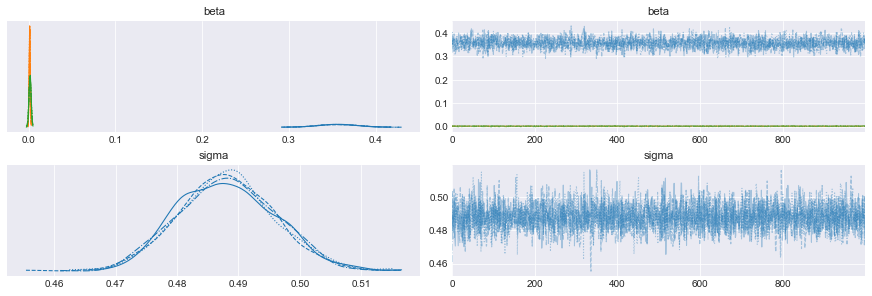

In [247]:
with pooled_model:
    pm.traceplot(pooled_trace)

In [248]:
## Save means of parameter estimates

b0, b1, b2 = pooled_trace['beta'].mean(axis=0)

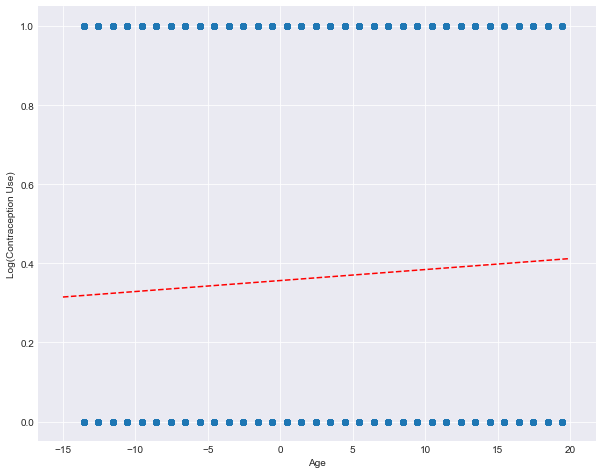

In [263]:
# Plot of the pooled model

plt.figure(figsize = (10,8))
plt.scatter(age, condom)
xvals = np.linspace(-15, 20)
plt.xlabel("Age")
plt.ylabel("Log(Contraception Use)")
plt.plot(xvals, (b0+b1*xvals+b2*xvals), 'r--')

In [250]:
districts = df.district.values
dist_unique = df.district.unique()
dist = len(dist_unique)
dist_lookup = dict(zip(dist_unique,range(len(dist_unique))))
district = df['districts_code'] = df.district.replace(dist_lookup).values
district

array([ 0,  0,  0, ..., 59, 59, 59], dtype=int64)

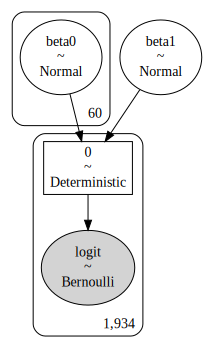

In [251]:
# Unpooled Model

with Model() as unpooled_model:

    beta0 = pm.Normal('beta0', 0, sd=1e5, shape=dist)
    beta1 = pm.Normal('beta1', 0, sd=1e5)

    likelihood = pm.invlogit(beta0[district] + beta1*age)
    theta=pm.Deterministic("0",likelihood)

    y = pm.Bernoulli("logit", theta, observed=condom)
pm.model_to_graphviz(unpooled_model)

In [252]:
## Trace plot

with unpooled_model:
    unpooled_trace = pm.sample(1000, cores = 4, tune=500)
    unpooled_idata = az.from_pymc3(unpooled_trace)
az.summary(pooled_idata, round_to=2)


<ipython-input-252-b8739c3db13e>:4: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  unpooled_trace = pm.sample(1000, cores = 4, tune=500)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\ProgramData\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: divide by zero encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in multiply
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta1, beta0]


Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 7569 seconds.
There were 885 divergences after tuning. Increase `target_accept` or reparameterize.
There were 939 divergences after tuning. Increase `target_accept` or reparameterize.
There were 970 divergences after tuning. Increase `target_accept` or reparameterize.
There were 994 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[0],0.36,0.02,0.32,0.4,0.0,0.0,2341.22,2185.55,1.0
beta[1],0.00,0.00,0.00,0.0,0.0,0.0,2287.45,2482.19,1.0
beta[2],0.00,0.00,-0.00,0.0,0.0,0.0,3099.96,2437.74,1.0
sigma,0.49,0.01,0.47,0.5,0.0,0.0,2930.24,2652.44,1.0


In [253]:
with unpooled_model:
    pm.traceplot(unpooled_trace)

<ipython-input-253-ab378367889c>:2: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(unpooled_trace)
C:\ProgramData\Anaconda3\lib\site-packages\arviz\stats\density_utils.py:248: RuntimeWarning: divide by zero encountered in double_scalars
  t_j = np.power((c1 * (c2 / (N * f))), (2.0 / (3.0 + 2.0 * j)))
C:\ProgramData\Anaconda3\lib\site-packages\arviz\stats\density_utils.py:252: RuntimeWarning: divide by zero encountered in double_scalars
  out = t - (2 * N * np.pi ** 0.5 * f) ** (-0.4)
C:\ProgramData\Anaconda3\lib\site-packages\arviz\stats\density_utils.py:276: RuntimeWarning: invalid value encountered in double_scalars
  bw = (_bw_silverman(x) / np.ptp(x)) ** 2
C:\ProgramData\Anaconda3\lib\site-packages\arviz\stats\density_utils.py:760: RuntimeWarning: invalid value encountered in true_divide
  f = grid_counts / bin_width / len(x)
C:\ProgramData\Anaconda3\lib\

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x0000026C396E1700> (for post_execute):


KeyboardInterrupt: 

In [254]:
# Unpooled estimates

unpooled_estimates = pd.Series(unpooled_trace['beta0'].mean(axis=0), index=dist_unique)
unpooled_se = pd.Series(unpooled_trace['beta0'].std(axis=0), index=dist_unique)
#unpooled_estimates
order = unpooled_estimates.sort_values().index

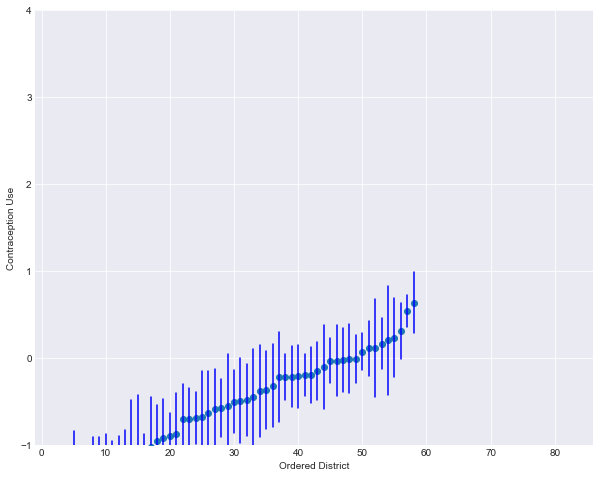

In [255]:
# Plot of the unpooled estimates NOTE TO GRADER: could not get indices to work properly.

plt.figure(figsize = (10,8))
plt.scatter(range(len(unpooled_estimates)), unpooled_estimates[order])
for i, m, se in zip(range(len(unpooled_estimates)), unpooled_estimates[order], unpooled_se[order]):
    plt.plot([i,i], [m-se, m+se], 'b-')
plt.xlim(-1,86); plt.ylim(-1,4)
plt.ylabel('Contraception Use');plt.xlabel('Ordered District');

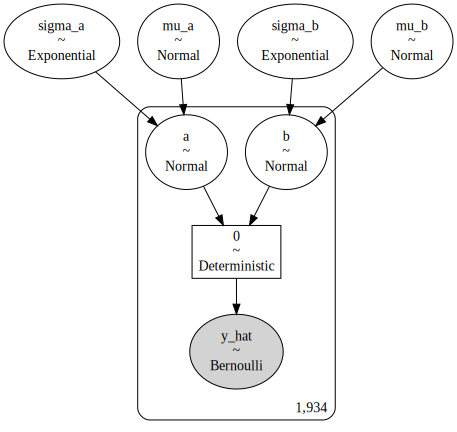

In [256]:
## Hierarchical model

with Model() as varying_intercept_slope:

    # Priors
    mu_a = pm.Normal('mu_a', mu=0., sd=1e5)
    sigma_a = pm.Exponential("sigma_a", 0.5)
    mu_b = pm.Normal('mu_b', mu=0., sd=1e5)
    #sigma_b =  pm.HalfCauchy('sigma_b', 10)
    sigma_b = pm.Exponential("sigma_b", .5)

    # Random intercepts
    a = pm.Normal('a', mu=mu_a, sd=sigma_a, shape=len(district))
    # Random slopes
    b = pm.Normal('b', mu=mu_b, sd=sigma_b, shape=len(district))

    # Data likelihood
    likelihood = pm.invlogit(a[district] + b[district] * age)
    theta= pm.Deterministic("0",likelihood)
    y_hat = pm.Bernoulli('y_hat', theta, observed=condom)

pm.model_to_graphviz(varying_intercept_slope)

In [258]:
with varying_intercept_slope:
    varying_intercept_slope_trace = pm.sample(1000, cores = 4, tune=500)
    varying_intercept_slope_idata = az.from_pymc3(varying_intercept_slope_trace)
az.summary(varying_intercept_slope_idata, round_to=2)

<ipython-input-258-5104c6fcf146>:2: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  varying_intercept_slope_trace = pm.sample(1000, cores = 4, tune=500)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, sigma_b, mu_b, sigma_a, mu_a]


ValueError: Not enough samples to build a trace.

In [ ]:
with varying_intercept_slope:
    pm.traceplot(varying_intercept_slope_trace)

In [ ]:
with varying_intercept_slope:
    plt.figure(figsize=(6,18))
    pm.forestplot(varying_intercept_slope_trace, var_names=['a','b']);